In [86]:
#import warnings
#warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import viz

import scipy
from scipy import stats
import sklearn.impute as simpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures



from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector


import prepare
import explore

# Prepare Data for Modeling
Wrangle

Acquired data from student-mat.csv.

Create dummy vars

Split data

Scale data

In [87]:
#ACQUIRE
df = sns.load_dataset("tips")
df["price_per_person"] = df["total_bill"]/df["size"]

#CREATE DUMMY
dummy_df = pd.get_dummies(data=df[df.select_dtypes(include=['category']).columns.tolist()], drop_first=False)
dummy_df.drop(columns=["sex_Male","smoker_No","time_Lunch"],inplace=True)

df = df.drop(columns=(df.select_dtypes(include=['category']).columns.tolist()))
df = pd.concat([df,dummy_df],axis=1)

pred = "tip"

cat_col = ["size","sex_Female","smoker_Yes",'day_Thur', 'day_Fri', 'day_Sat', 'day_Sun',
       'time_Dinner']
num_col = ["total_bill","price_per_person"
]

#SPLIT
from sklearn.model_selection import train_test_split

train,test = train_test_split(df,test_size= .2, random_state=123)
train,validate = train_test_split(train,test_size= .25, random_state=123)


not_pred=df.columns.drop(pred).tolist()


X_train,y_train = train[not_pred],train[pred]
X_validate,y_validate = validate[not_pred],validate[pred]
X_test,y_test = test[not_pred],test[pred]


#SCALE THE DATA
scaler = MinMaxScaler(copy=True).fit(X_train[num_col])
# scale X_train, X_validate, X_test using the mins and maxes stored in the scaler derived from X_train.
#
X_train_scaled_array = scaler.transform(X_train[num_col])
X_validate_scaled_array = scaler.transform(X_validate[num_col])
X_test_scaled_array = scaler.transform(X_test[num_col])
# convert arrays to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=num_col).set_index(
    [X_train.index.values]
)
X_validate_scaled = pd.DataFrame(
    X_validate_scaled_array, columns=num_col
).set_index([X_validate.index.values])
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=num_col).set_index(
    [X_test.index.values]
)


In [88]:
X_train.head()

,total_bill,size,price_per_person,sex_Female,smoker_Yes,day_Thur,day_Fri,day_Sat,day_Sun,time_Dinner
224,13.42,2,6.710000,0,1,0,1,0,0,0
181,23.33,2,11.665000,0,1,0,0,0,1,1
102,44.30,3,14.766667,1,1,0,0,1,0,1
164,17.51,2,8.755000,1,1,0,0,0,1,1
73,25.28,2,12.640000,1,1,0,0,1,0,1


In [89]:
y_train

224    1.58
181    5.65
102    2.50
164    3.00
73     5.00
       ... 
233    1.47
6      2.00
7      3.12
115    3.50
166    2.24
Name: tip, Length: 146, dtype: float64

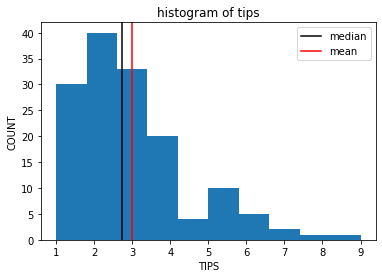

In [90]:
baseline_mean_tips = y_train.mean()
baseline_median_tips = y_train.median()

plt.hist(y_train)
plt.axvline(x=baseline_median_tips,color="black",label="median")
plt.axvline(x=baseline_mean_tips,color="red",label="mean")
plt.xlabel("TIPS")
plt.ylabel("COUNT")
plt.legend()
plt.title("histogram of tips")
plt.show()


In [91]:
#determining best baseline
y_train=pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

y_train["mean"] = baseline_mean_tips
y_validate["mean"] = baseline_mean_tips

y_train["median"] = baseline_median_tips
y_validate["median"] = baseline_median_tips



In [93]:
##want smallest error

rmse_mean_train = mean_squared_error(y_train.tip, y_train["mean"])**(1/2)
rmse_mean_validate = mean_squared_error(y_validate.tip, y_validate["mean"])**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_mean_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_mean_validate, 2))


rmse_median_train = mean_squared_error(y_train.tip, y_train["median"])**(1/2)
rmse_median_validate = mean_squared_error(y_validate.tip, y_validate["median"])**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_median_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_median_validate, 2))

RMSE using Mean
Train/In-Sample:  1.45 
Validate/Out-of-Sample:  1.53
RMSE using Median
Train/In-Sample:  1.47 
Validate/Out-of-Sample:  1.57


mean is lowest, will use that moving forward

In [94]:
metric_df = pd.DataFrame(
    data=[{
        "model":"mean_baseline",
        "rmse_validate":rmse_mean_validate,
        "r^2_validate":explained_variance_score(y_validate.tip,y_validate["mean"])
    }]
)

# LinearRegression (OLS)
Fit the model using X_train_scaled and the labels from y_train.

Predict final grade for students in training sample using our model (lm).

Evaluate using RMSE

Repeat predictions and evaluation for validation.

Compare RMSE train vs. validation. Overfitting?

In [97]:
# create the model object
linreg = LinearRegression()

# fit the model to our training data. 
linreg.fit(X_train_scaled, y_train["tip"])

# predict train
y_train['tip_pred_linreg'] = linreg.predict(X_train_scaled)

# evaluate: rmse
rmse_linreg_train = mean_squared_error(y_train.tip, y_train.tip_pred_linreg)**(1/2)

# predict validate
y_validate['tip_pred_linreg'] = linreg.predict(X_validate_scaled)

# evaluate: rmse
rmse_linreg_validate = mean_squared_error(y_validate.tip, y_validate.tip_pred_linreg)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_linreg_train, 
      "\nValidation/Out-of-Sample: ", rmse_linreg_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  1.063214809472265 
Validation/Out-of-Sample:  1.0184993840309196


In [98]:
metric_df.loc[len(metric_df.index)] = ["OLS lm 1",
                                        rmse_linreg_train,
                                        explained_variance_score(y_validate.tip,y_validate["tip_pred_linreg"])
                                    ]

# LassoLars
Fit the model using X_train_scaled and the labels from y_train.

Predict final grade for students in training sample using our model (lars).

Evaluate using RMSE

Repeat predictions and evaluation for validation.

Compare RMSE train vs. validation. Overfitting?

In [99]:
# create the model object
l_lars = LassoLars(alpha=1)

# fit the model to our training data. 
l_lars.fit(X_train_scaled, y_train["tip"])

# predict train
y_train['tip_pred_l_lars'] = l_lars.predict(X_train_scaled)

# evaluate: rmse
rmse_l_lars_train = mean_squared_error(y_train.tip, y_train.tip_pred_l_lars)**(1/2)

# predict validate
y_validate['tip_pred_l_lars'] = l_lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_l_lars_validate = mean_squared_error(y_validate.tip, y_validate.tip_pred_l_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_l_lars_train, 
      "\nValidation/Out-of-Sample: ", rmse_l_lars_validate)

RMSE for Lasso + Lars
Training/In-Sample:  1.451105446961829 
Validation/Out-of-Sample:  1.5258133479910245


/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [100]:
metric_df.loc[len(metric_df.index)] = ["Lasso lars 1",
                                        rmse_l_lars_train,
                                        explained_variance_score(y_validate.tip,y_validate["tip_pred_l_lars"])
                                    ]

# TweedieRegressor (GLM)
Fit the model using X_train_scaled and the labels from y_train.

Predict final grade for students in training sample using our model (glm).

Evaluate using RMSE

Repeat predictions and evaluation for validation.

Compare RMSE train vs. validation. Overfitting?

In [101]:
# create the model object
glm = TweedieRegressor(power=1,alpha=0)

# fit the model to our training data. 
glm.fit(X_train_scaled, y_train["tip"])

# predict train
y_train['tip_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_glm_train = mean_squared_error(y_train.tip, y_train.tip_pred_glm)**(1/2)

# predict validate
y_validate['tip_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_glm_validate = mean_squared_error(y_validate.tip, y_validate.tip_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_glm_train, 
      "\nValidation/Out-of-Sample: ", rmse_glm_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  1.093702460370466 
Validation/Out-of-Sample:  0.9730664763765419


In [102]:
metric_df.loc[len(metric_df.index)] = ["Tweedie 1",
                                        rmse_glm_train,
                                        explained_variance_score(y_validate.tip,y_validate["tip_pred_glm"])
                                    ]

metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,1.525813,3.330669e-16
1,OLS lm 1,1.063215,5.507265e-01
2,Lasso lars 1,1.451105,2.220446e-16
3,Tweedie 1,1.093702,5.887661e-01


In [103]:
y_train

,tip,mean,median,tip_pred_linreg,tip_pred_l_lars,tip_pred_glm
224,1.58,2.981096,2.73,2.355143,2.981096,2.404138
181,5.65,2.981096,2.73,3.105786,2.981096,3.013595
102,2.50,2.981096,2.73,5.499568,2.981096,5.822219
164,3.00,2.981096,2.73,2.664944,2.981096,2.639108
73,5.00,2.981096,2.73,3.253491,2.981096,3.150599
...,...,...,...,...,...,...
233,1.47,2.981096,2.73,2.154416,2.981096,2.263185
6,2.00,2.981096,2.73,2.002924,2.981096,2.162304
7,3.12,2.981096,2.73,4.107714,2.981096,3.850890
115,3.50,2.981096,2.73,2.649795,2.981096,2.627101


# Polynomial Regression
Using sklearn.preprocessing.PolynommialFeatures() + sklearn.linear_model.LinearRegression()

Create the new features, based on value indicated for degree for train, validate & test.

Fit the Linear Regression model

Predict using the transformed (squared or cubed, e.g.) features

Evaluate using RMSE

Repeat predictions and evaluation for validation.

Compare RMSE train vs. validation. Overfitting?

In [104]:

pf = PolynomialFeatures(degree=2)

X_train_degree2 = pf.fit_transform(X_train_scaled)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)


# create the model object
lm2 = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tip)

# predict train
y_train['tip_pred_lm2'] = lm2.predict(X_train_degree2)

y_train

# evaluate: rmse
rmse_pf_train = mean_squared_error(y_train.tip, y_train.tip_pred_lm2)**(1/2)

# predict validate
y_validate['tip_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_pf_validate = mean_squared_error(y_validate.tip, y_validate.tip_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_pf_train, 
      "\nValidation/Out-of-Sample: ", rmse_pf_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  1.0318755896520801 
Validation/Out-of-Sample:  1.1275284327942152


In [105]:
metric_df.loc[len(metric_df.index)] = ["Polynomial Fit 1",
                                        rmse_pf_train,
                                        explained_variance_score(y_validate.tip,y_validate["tip_pred_lm2"])
                                    ]

metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,1.525813,3.330669e-16
1,OLS lm 1,1.063215,5.507265e-01
2,Lasso lars 1,1.451105,2.220446e-16
3,Tweedie 1,1.093702,5.887661e-01
4,Polynomial Fit 1,1.031876,4.509982e-01


takeaways:
linear regression is doing the best,
regularization did not have benefitial effects on generalization
polynomial regression overfit even at n=1 degree
Tweedie had a larger seperation of values from linear regression, concern with overfit, also not a poisson distribution (tips was not time dependant variable)

# Evaluate
Plotting Actual vs. Predicted Values

In [106]:
y_validate.head(1)

,tip,mean,median,tip_pred_linreg,tip_pred_l_lars,tip_pred_glm,tip_pred_lm2
162,2.0,2.981096,2.73,2.861177,2.981096,2.736908,2.78288


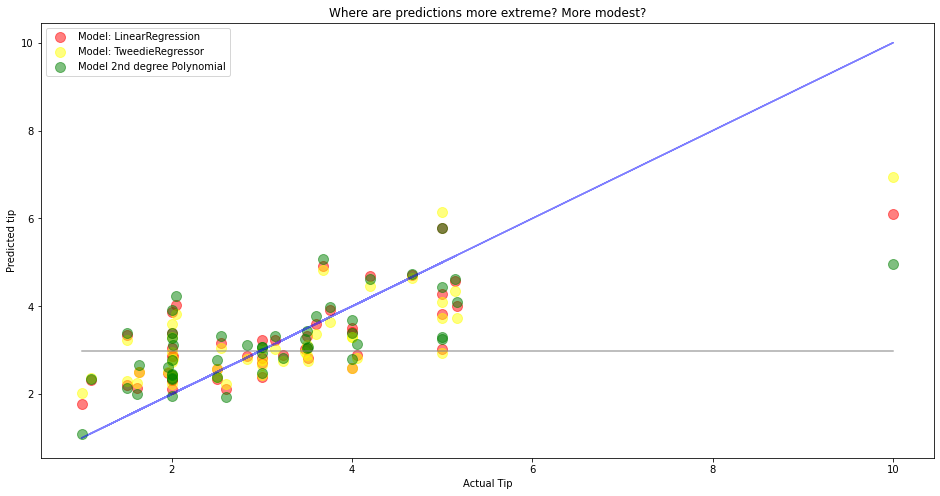

In [107]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tip, y_validate["mean"], alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tip, y_validate.tip, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tip, y_validate.tip_pred_linreg, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tip, y_validate.tip_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tip, y_validate.tip_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tip")
plt.ylabel("Predicted tip")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

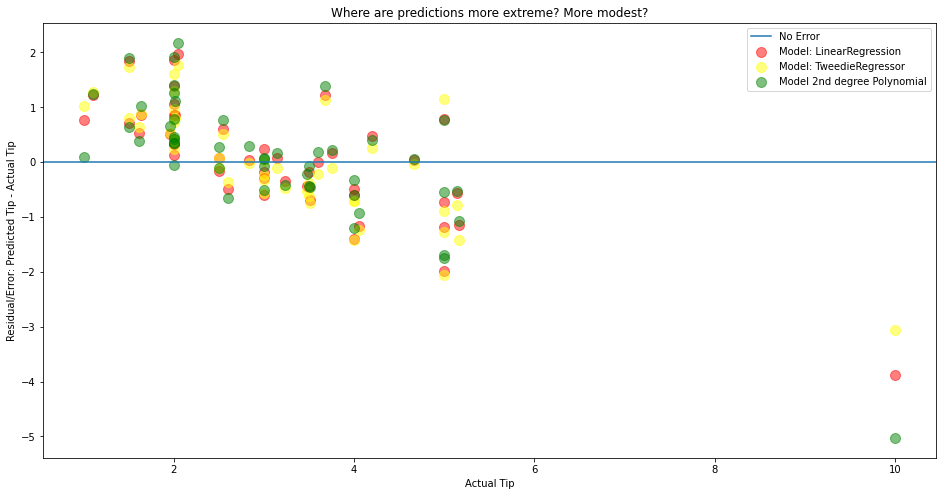

In [108]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tip, y_validate.tip_pred_linreg-y_validate.tip, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tip, y_validate.tip_pred_glm-y_validate.tip, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tip, y_validate.tip_pred_lm2-y_validate.tip, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tip")
plt.ylabel("Residual/Error: Predicted Tip - Actual Tip")
plt.title("Where are predictions more extreme? More modest?")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


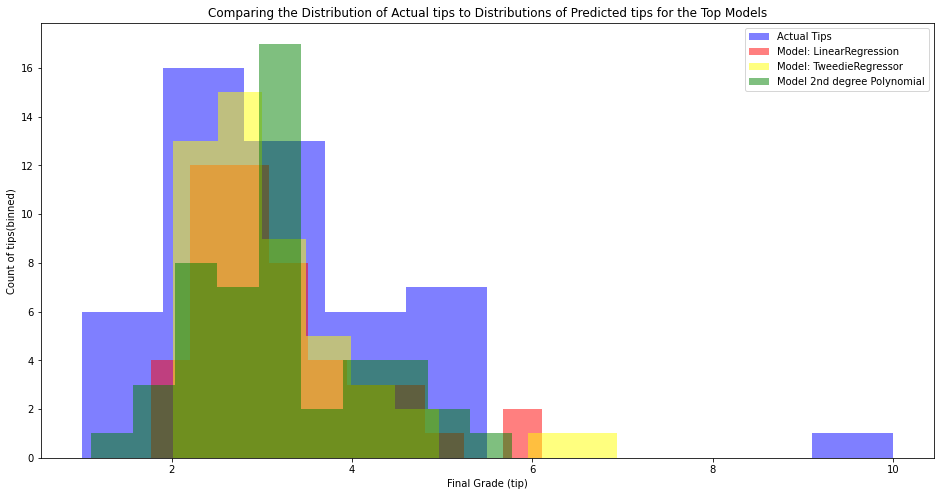

In [109]:


# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tip, color='blue', alpha=.5, label="Actual Tips")
plt.hist(y_validate.tip_pred_linreg, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tip_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.tip_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Final Grade (tip)")
plt.ylabel("Count of tips(binned)")
plt.title("Comparing the Distribution of Actual tips to Distributions of Predicted tips for the Top Models")
plt.legend()
plt.show()


Model selected: LinearRegression due to low/consisent error values

In [115]:
y_test = pd.DataFrame(y_test)
y_test["tip_pred_linreg"] = linreg.predict(X_test_scaled)

rmse_linreg_test = mean_squared_error(y_test.tip, y_test.tip_pred_linreg)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/train: ", rmse_linreg_train, 
      "\nValidation/: ", rmse_linreg_validate,
      "\ntest/: ", rmse_linreg_test)

RMSE for OLS using LinearRegression
Training/train:  1.063214809472265 
Validation/:  1.0184993840309196 
test/:  0.8182923378215017
